In [30]:
import pandas as pd
import sqlalchemy as sqla
from scipy.stats import spearmanr
import numpy as np
import sys
sys.path.append('../code')
import Functions

In [10]:
##Import Full Dataset
engine = sqla.create_engine('sqlite:///top200data')
df_all = pd.read_sql('select * from top200data',engine)
feat_df = pd.read_csv("../data/songsdata.csv")

In [32]:
def rbo(list1, list2, p=0.9):
   import math
    # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

In [25]:
##List of Dates
import datetime
start_date = datetime.date(2017, 1, 6)
end_date = datetime.date(2020, 12, 25)
delta = datetime.timedelta(days = 7)
ls_date = []
while start_date <= end_date:
    ls_date.append(str(start_date))
    start_date += delta

In [33]:
#RBO Between Two Countries # 2 plots
rbo_df = pd.DataFrame(columns = ["date","rboscore"])
for i in range(len(df_all["date"].unique())):
    readdf = pd.read_sql(f'select * from top200data where date = "{ls_date[i]}"',engine)
    merge_temp = pd.merge(readdf, feat_df, on= "songcode")
    ussongs_list = list(merge_temp[merge_temp["regioncode"] == "us"]["song_x"])
    casongs_list = list(merge_temp[merge_temp["regioncode"] == "ca"]["song_x"])
    rbo_df.loc[i] = [f"{ls_date[i]}", rbo(ussongs_list,casongs_list, p = 0.8)]


In [ ]:
rbo_df["date"] = pd.to_datetime(rbo_df['date'],format='%Y-%m-%d')
rbo_df.plot("date" , "rboscore", color = "r")

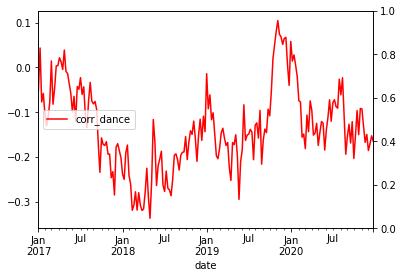

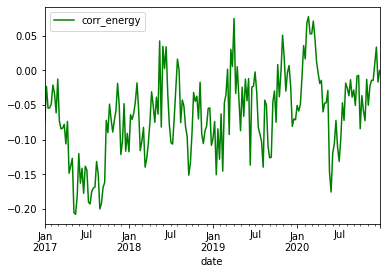

In [35]:
##Plot Feature Correlations Across Time

plot_df = pd.read_csv("../data/correlationsdata.csv")
plot_df["date"] = pd.to_datetime(plot_df['date'],format='%Y-%m-%d')
plot1 = plot_df.plot("date" , "corr_dance", color = "r")
plot1ax = plot1.twinx()
plot_df.plot("date" , "corr_energy",color = "g")
plot1.legend(loc = "center left")

In [66]:
##Genre Plot
artist = pd.read_sql('SELECT * FROM top200data WHERE artist IS NOT NULL', engine)
artist['streams'] = artist['streams'].apply(lambda x: int(x.replace(",","")))
artist['artist'] = artist['artist'].apply(lambda x: x.split(', ')[0])

genre = artist.copy().groupby(['artist','date']).streams.sum().to_frame().reset_index()\
                        .merge(pd.read_csv('../data/artistsdata.csv'), left_on="artist", right_on="artist").dropna()
genre['genre'] = genre['genre'].apply(lambda x: str(x)[1:-1].replace("'","").split(", "))
genre = genre.explode('genre').groupby(['genre','date']).streams.sum().to_frame().reset_index()  


In [77]:
genre.groupby('genre').streams.sum().to_frame()['streams'].sort_values(ascending=False)[:5].keys()

Index(['pop', 'rap', 'latin', 'trap latino', 'reggaeton'], dtype='object', name='genre')

In [75]:
genre.to_csv('../data/genredata.csv')

In [78]:
genre

,genre,date,streams
0,"""childrens music""",2020-01-17,11882
1,"""childrens music""",2020-01-24,11780
2,"""childrens music""",2020-01-31,11366
3,"""childrens music""",2020-02-07,11128
4,"""preschool childrens music""",2020-01-17,11882
...,...,...,...
64715,zouk riddim,2018-12-07,18508
64716,zouk riddim,2018-12-14,18273
64717,zouk riddim,2018-12-21,17752
64718,zouk riddim,2018-12-28,17050


In [79]:
rbo_df

,date,rboscore
0,2017-01-06,1.000000
1,2017-01-13,1.000000
2,2017-01-20,0.999999
3,2017-01-27,1.000000
4,2017-02-03,1.000000
...,...,...
203,2020-11-27,0.998570
204,2020-12-04,0.999998
205,2020-12-11,1.000000
206,2020-12-18,1.000000
